In [1]:
# Import the necessary Python libraries
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import log10
import math
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib import colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import os.path
import csv
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
DATA_DIR = "/collobrative_transport/data"

In [3]:
ROBOTS = [25,50,100]
PATH_TAKEN = ['straight', 'zigzac', 'straight_rot']
INTER_CAGE_DIST =0.45 # 0.65, 0.85
MASS = 5
OBJECT_SHAPE = [0,1,2]
STATE=[0,1] # 0-> caging 1-> pushing
REP=30
TARGET_x=[-10,-10]
TARGET_y=[-0,-2]
TARGET_TOLERENCE = 1
TARGET_TOLERENCE_100 = 3.5
TIME_STEP=10

In [4]:
print("EXPERIMENTAL DATA FILES STATS")
for robot in ROBOTS:
    for path in PATH_TAKEN:
        
        object_shape = 0
        if(robot == 50):
            object_shape = 1
        elif(robot == 100):
            object_shape = 2
        for movement in [0]:
            for rep in range(1,REP+1):
                if (not os.path.exists(DATA_DIR+"/pos_"+str(robot)+'_'+path+'_'
                                      +str(INTER_CAGE_DIST)+'_'+str(MASS)+'_'
                                      +str(object_shape)+'_'+str(rep)
                                      +'.csv')) or (not os.path.exists(DATA_DIR
                                      +"/perf_"+str(robot)+'_'+path+'_'+str(INTER_CAGE_DIST)+'_'
                                      +str(MASS)+'_'+str(object_shape)+'_'+str(rep)
                                      +'.csv')) or (not os.path.exists(DATA_DIR
                                      +"/effec_"+str(robot)+'_'+path+'_'+str(INTER_CAGE_DIST)+'_'
                                      +str(MASS)+'_'+str(object_shape)+'_'+str(rep)+'.csv')):
                    print("EXP: ROBOT {} PATH {} REP {} does not exist".format(robot,path,rep))
                    print(DATA_DIR+"/pos_"+str(robot)+'_'+path+'_'+str(INTER_CAGE_DIST)+'_'+str(MASS)+'_'+str(object_shape)+'_'+str(rep)+'.csv')
                    

EXPERIMENTAL DATA FILES STATS
EXP: ROBOT 25 PATH straight_rot REP 21 does not exist
/collobrative_transport/data/pos_25_straight_rot_0.45_5_0_21.csv
EXP: ROBOT 100 PATH straight REP 5 does not exist
/collobrative_transport/data/pos_100_straight_0.45_5_2_5.csv
EXP: ROBOT 100 PATH zigzac REP 5 does not exist
/collobrative_transport/data/pos_100_zigzac_0.45_5_2_5.csv
EXP: ROBOT 100 PATH straight_rot REP 5 does not exist
/collobrative_transport/data/pos_100_straight_rot_0.45_5_2_5.csv
EXP: ROBOT 100 PATH straight_rot REP 13 does not exist
/collobrative_transport/data/pos_100_straight_rot_0.45_5_2_13.csv
EXP: ROBOT 100 PATH straight_rot REP 29 does not exist
/collobrative_transport/data/pos_100_straight_rot_0.45_5_2_29.csv


In [5]:
def get_names_for_posfile(robot):
    name = ['time']
    for i in range(0,robot):
        name.append('id:'+str(i))
        name.append('x_'+str(i))
        name.append('y_'+str(i))
        name.append('z_'+str(i))
    name.append('obj_x')
    name.append('obj_y')
    name.append('obj_yaw')
    return name
def get_names_for_effecfile(robot):
    name = ['time']
    for i in range(0,robot):
        name.append('id:'+str(i))
        name.append('ep_'+str(i))
        name.append('er_'+str(i))
        name.append('task_'+str(i))
        name.append('c_size_'+str(i))
        name.append('p_size_'+str(i))
        name.append('r_size_'+str(i))
        name.append('t_size_'+str(i))
    return name

In [6]:
# Reads the data of a single experiment
def read_pos_datafile(name, robot):
    fname = DATA_DIR + "/pos_" + name
    print('Reading: '+fname+'.csv')
    names = get_names_for_posfile(robot)
    if not os.path.exists(fname+'.csv'):
        print("File does not exsist "+fname+'.csv')
        return pd.DataFrame()
    return pd.read_csv(fname+'.csv', names=names, header=None, skiprows=1, engine='python')

In [7]:
# Reads the data of a single experiment
def read_effec_datafile(name, robot):
    fname = DATA_DIR + "/effec_" + name
    print('Reading: '+fname+'.csv')
    names = get_names_for_effecfile(robot)
    if not os.path.exists(fname+'.csv'):
        print("File does not exsist "+fname+'.csv')
        return pd.DataFrame()
    return pd.read_csv(fname+'.csv', names=names, header=None, skiprows=1, engine='python')

In [8]:
def dist(row,x1,y1):
    return math.hypot((row['obj_x']-x1),(row['obj_y']-y1))

In [9]:
def get_time_for_obj_at_tar(c_df, setting, robot):
    if(setting <=1):
        c_df[['obj_dis']] = c_df.apply(dist,x1=TARGET_x[0],y1=TARGET_y[0],axis = 1).apply(pd.Series)
    else:
        c_df[['obj_dis']] = c_df.apply(dist,x1=TARGET_x[1],y1=TARGET_y[1],axis = 1).apply(pd.Series)
    tar_Tol = TARGET_TOLERENCE
    if(robot == 100):
        tar_Tol = TARGET_TOLERENCE_100
    end_time = c_df[c_df['obj_dis']<= tar_Tol].index.tolist()
    if(len(end_time) <= 0):
        print(' Could not find the last target dist, Declare the last time step as end exp :'+str(len(c_df)))
        return len(c_df)
    else:
        print('end time '+str(end_time[0])+'size: '+str(len(c_df)))
        return end_time[0]

In [10]:
def get_caging_time(c_df, robot):
    largest_Time = 0
    c_robot = 0
    for d in range(0,robot):
        stateTime = c_df[c_df['c_size_'+str(d)] > 0].index.tolist()
        if(len(stateTime) > 0 and stateTime[0] > largest_Time):
            largest_Time = stateTime[0]
            c_robot = d
    stateTime = c_df[c_df['c_size_'+str(c_robot)] == 0].index.tolist()
    for i in range(0,len(stateTime)):
        if(stateTime[i] > largest_Time):
            print('cage time: '+str(stateTime[i])+' size '+str(len(c_df)))
            return stateTime[i]

In [11]:
pos_df = read_pos_datafile('25_zigzac_0.45_5_0_16',25)

Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_16.csv


In [12]:
get_time_for_obj_at_tar(pos_df,2,25)

end time 4213size: 4318


4213

In [13]:
effec_df = read_effec_datafile('100_straight_0.45_5_2_1',100)

Reading: /collobrative_transport/data/effec_100_straight_0.45_5_2_1.csv


In [14]:
get_caging_time(effec_df,100)

cage time: 65411 size 66617


65411

In [15]:
len(effec_df)

66617

In [39]:
# Makes a series of raw data out of a set of experiments
def static_make_series_data(robots, path, obj_shape, state, irreg):
    # Create series to contain the result
    res = pd.Series()
    res.set_value(0, robots)   
    res.set_value(1, obj_shape)
    res.set_value(2, path)
    res.set_value(3, state)
    # to indicate that zig azc has a different target 
    c_setting = 0
    if(path == 'zigzac'):
        c_setting= 2
    for i in range(1,REP+1):
        if(state == 0 and not read_effec_datafile(str(robots)+'_'+path+'_'+str(INTER_CAGE_DIST)
                                                           +'_'+str(MASS)+'_'+str(obj_shape)+'_'+str(i),robots).empty):
            if irreg == 1:
                log_time = len(read_effec_datafile(str(robots)+'_'+path+'_'+str(INTER_CAGE_DIST)
                                                           +'_'+str(MASS)+'_'+str(obj_shape)+'_'+str(i),robots))
                res.set_value(i+4, log_time)
            else:
                log_time = get_caging_time(read_effec_datafile(str(robots)+'_'+path+'_'+str(INTER_CAGE_DIST)
                                                               +'_'+str(MASS)+'_'+str(obj_shape)+'_'+str(i),robots),robots)
                res.set_value(i+4, log_time)
        elif(state == 1 and not read_pos_datafile(str(robots)+'_'+path+'_'+str(INTER_CAGE_DIST)
                                                           +'_'+str(MASS)+'_'+str(obj_shape)+'_'+str(i),robots).empty):
            log_time = get_time_for_obj_at_tar(read_pos_datafile(str(robots)+'_'+path+'_'+str(INTER_CAGE_DIST)
                                                           +'_'+str(MASS)+'_'+str(obj_shape)+'_'+str(i),robots),c_setting, robots)
            res.set_value(i+4, log_time)
    return res

# Makes a complete table of raw data
def static_make_table_data():
    # Store data here
    df = pd.DataFrame()
    # Fill in the data, one series at a time
    for robots in ROBOTS:
        for path in PATH_TAKEN:
            for state in STATE:
                obj_shape = 0
                if(robots == 50):
                    obj_shape = 1
                elif(robots == 100):
                    obj_shape = 2 
                df = df.append(static_make_series_data(robots, path, obj_shape, state, 0), ignore_index=True)
    
    robots = 30
    path='n'
    state = 0
    for obj_shape in [3,4,5]:
        df = df.append(static_make_series_data(robots, path, obj_shape, state, 1), ignore_index=True)
        
    # Return the dataframe
    df.set_index([0, 1, 2, 3], inplace=True)
    df.index.names = ["robots", "Object_shape", "path", "State"]
    df.columns = range(1, REP+1)
    return df

In [40]:
data = static_make_table_data()

Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_1.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_1.csv
cage time: 2772 size 3914
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_2.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_2.csv
cage time: 2657 size 3797
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_3.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_3.csv
cage time: 2846 size 3975
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_4.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_4.csv
cage time: 2606 size 3747
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_5.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_5.csv
cage time: 2657 size 3830
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_6.csv
Reading: /collobrative_transport/data/effec_25_straight_0.45_5_0_6.csv
cage time: 2610 si

Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_20.csv
end time 3648size: 3756
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_21.csv
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_21.csv
end time 3696size: 3808
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_22.csv
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_22.csv
end time 3499size: 3607
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_23.csv
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_23.csv
end time 3989size: 4094
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_24.csv
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_24.csv
end time 3510size: 3616
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_25.csv
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_25.csv
end time 3502size: 3609
Reading: /collobrative_transport/data/pos_25_straight_0.45_5_0_26.csv
Reading: /collob

end time 4584size: 4704
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_11.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_11.csv
end time 4522size: 4630
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_12.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_12.csv
end time 3927size: 4034
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_13.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_13.csv
end time 4238size: 4342
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_14.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_14.csv
end time 4035size: 4162
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_15.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_15.csv
end time 3949size: 4061
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_16.csv
Reading: /collobrative_transport/data/pos_25_zigzac_0.45_5_0_16.csv
end time 4213size: 4318
Reading: /collob

Reading: /collobrative_transport/data/effec_25_straight_rot_0.45_5_0_29.csv
cage time: 2068 size 3531
Reading: /collobrative_transport/data/effec_25_straight_rot_0.45_5_0_30.csv
Reading: /collobrative_transport/data/effec_25_straight_rot_0.45_5_0_30.csv
cage time: 2890 size 4312
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_1.csv
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_1.csv
end time 4099size: 4208
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_2.csv
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_2.csv
end time 3985size: 4092
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_3.csv
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_3.csv
end time 4163size: 4274
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_4.csv
Reading: /collobrative_transport/data/pos_25_straight_rot_0.45_5_0_4.csv
end time 3912size: 4023
Reading: /collobrative_transport/data/po

cage time: 8816 size 9957
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_18.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_18.csv
cage time: 9035 size 10181
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_19.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_19.csv
cage time: 8737 size 9881
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_20.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_20.csv
cage time: 7797 size 8937
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_21.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_21.csv
cage time: 8123 size 9258
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_22.csv
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_22.csv
cage time: 9930 size 11069
Reading: /collobrative_transport/data/effec_50_straight_0.45_5_1_23.csv
Reading: /collobrative_transport/data/effec_50_str

Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_7.csv
cage time: 7766 size 9545
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_8.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_8.csv
cage time: 7488 size 9284
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_9.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_9.csv
cage time: 7999 size 9795
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_10.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_10.csv
cage time: 8078 size 9897
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_11.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_11.csv
cage time: 7838 size 9624
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_12.csv
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_12.csv
cage time: 7508 size 9293
Reading: /collobrative_transport/data/effec_50_zigzac_0.45_5_1_13.csv
Reading: 

end time 9573size: 9679
Reading: /collobrative_transport/data/pos_50_zigzac_0.45_5_1_28.csv
Reading: /collobrative_transport/data/pos_50_zigzac_0.45_5_1_28.csv
end time 9799size: 9921
Reading: /collobrative_transport/data/pos_50_zigzac_0.45_5_1_29.csv
Reading: /collobrative_transport/data/pos_50_zigzac_0.45_5_1_29.csv
end time 10508size: 10632
Reading: /collobrative_transport/data/pos_50_zigzac_0.45_5_1_30.csv
Reading: /collobrative_transport/data/pos_50_zigzac_0.45_5_1_30.csv
end time 8903size: 9025
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_5_1_1.csv
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_5_1_1.csv
cage time: 8460 size 10135
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_5_1_2.csv
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_5_1_2.csv
cage time: 8526 size 10195
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_5_1_3.csv
Reading: /collobrative_transport/data/effec_50_straight_rot_0.45_

end time 9988size: 10092
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_15.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_15.csv
end time 9319size: 9423
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_16.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_16.csv
end time 9566size: 9674
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_17.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_17.csv
end time 10394size: 10499
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_18.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_18.csv
end time 10600size: 10705
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_19.csv
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_19.csv
end time 10302size: 10409
Reading: /collobrative_transport/data/pos_50_straight_rot_0.45_5_1_20.csv
Reading: /collobrative_transport/da

Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_2.csv
end time 29357size: 29879
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_3.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_3.csv
end time 27899size: 28375
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_4.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_4.csv
end time 46990size: 47487
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_5.csv
File does not exsist /collobrative_transport/data/pos_100_straight_0.45_5_2_5.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_6.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_6.csv
end time 30380size: 30833
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_7.csv
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_7.csv
end time 26931size: 27430
Reading: /collobrative_transport/data/pos_100_straight_0.45_5_2_8.csv
Reading: /collobra

Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_21.csv
cage time: 27254 size 28912
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_22.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_22.csv
cage time: 27866 size 29535
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_23.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_23.csv
cage time: 34898 size 36575
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_24.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_24.csv
cage time: 27739 size 29399
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_25.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_25.csv
cage time: 27997 size 29661
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_26.csv
Reading: /collobrative_transport/data/effec_100_zigzac_0.45_5_2_26.csv
cage time: 41937 size 43595
Reading: /collobrative_transport/data/effec_100_zig

Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_10.csv
cage time: 30639 size 109787
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_11.csv
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_11.csv
cage time: 28198 size 132664
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_12.csv
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_12.csv
cage time: 34537 size 36663
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_13.csv
File does not exsist /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_13.csv
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_14.csv
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_14.csv
cage time: 27809 size 30007
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_15.csv
Reading: /collobrative_transport/data/effec_100_straight_rot_0.45_5_2_15.csv
cage time: 27538 size 13575

end time 43608size: 44394
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_27.csv
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_27.csv
end time 34498size: 125088
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_28.csv
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_28.csv
end time 36975size: 125218
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_29.csv
File does not exsist /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_29.csv
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_30.csv
Reading: /collobrative_transport/data/pos_100_straight_rot_0.45_5_2_30.csv
end time 55607size: 56607
Reading: /collobrative_transport/data/effec_30_n_0.45_5_3_1.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_3_1.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_3_2.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_3_2.csv
Reading: /collobrative_tra

Reading: /collobrative_transport/data/effec_30_n_0.45_5_4_28.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_4_29.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_4_29.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_4_30.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_4_30.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_5_1.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_5_1.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_5_2.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_5_2.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_5_3.csv
File does not exsist /collobrative_transport/data/effec_30_n_0.45_5_5_3.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_5_4.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_5_4.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_5_5.csv
Reading: /collobrative_transport/data/effec_30_n_0.45_5_5_5.csv
Reading: /collobrative_

In [41]:
data.stack().groupby(level=[0,1,2,3]).describe().unstack()

count          mean          std  \
robots Object_shape path         State                                     
25     0            straight     0         30   2568.466667   244.388996   
                                 1         30   3600.266667   242.877283   
                    straight_rot 0         29   2566.517241   248.477309   
                                 1         29   3884.965517   237.688795   
                    zigzac       0         30   2568.466667   244.388996   
                                 1         30   4199.533333   226.045728   
30     3            n            0         28   2943.535714   201.527956   
       4            n            0         29   4087.379310   297.425190   
       5            n            0         27   2853.851852   117.723831   
50     1            straight     0         30   8260.600000   591.644208   
                                 1         30   9292.533333   592.318166   
                    straight_rot 0         30   8260.600000   591.644208   
                                 1         30   9832.333333   591.643959   
                    zigzac       0         30   8260.600000   591.644208   
                                 1         30   9923.866667   590.767340   
100    2            straight     0         29  33261.931034  9527.341024   
                                 1         29  33964.655172  9533.254823   
                    straight_rot 0         27  32422.074074  9329.481760   
                                 1         27  34074.703704  9325.227738   
                    zigzac       0         29  33261.931034  9527.341024   
                                 1         29  34405.172414  9529.729643   

                                          min       25%      50%       75%  \
robots Object_shape path         State                                       
25     0            straight     0       2068   2471.00   2607.0   2685.50   
                                 1       3103   3499.00   3633.0   3747.50   
                    straight_rot 0       2068   2470.00   2606.0   2695.00   
                                 1       3427   3762.00   3912.0   3999.00   
                    zigzac       0       2068   2471.00   2607.0   2685.50   
                                 1       3795   4108.25   4213.5   4301.00   
30     3            n            0       2642   2798.00   2947.0   3057.50   
       4            n            0       3583   3905.00   4024.0   4285.00   
       5            n            0       2699   2762.00   2813.0   2920.50   
50     1            straight     0       7230   7797.00   8130.5   8732.00   
                                 1       8254   8828.50   9158.5   9766.75   
                    straight_rot 0       7230   7797.00   8130.5   8732.00   
                                 1       8799   9371.25   9715.0  10295.00   
                    zigzac       0       7230   7797.00   8130.5   8732.00   
                                 1       8903   9467.50   9804.0  10406.00   
100    2            straight     0      26242  27538.00  28198.0  34898.00   
                                 1      26931  28237.00  28883.0  35601.00   
                    straight_rot 0      26242  27423.00  27997.0  33690.50   
                                 1      27872  29087.00  29657.0  35333.00   
                    zigzac       0      26242  27538.00  28198.0  34898.00   
                                 1      27380  28687.00  29336.0  36032.00   

                                          max  
robots Object_shape path         State         
25     0            straight     0       2984  
                                 1       3997  
                    straight_rot 0       2984  
                                 1       4304  
                    zigzac       0       2984  
                                 1       4593  
30     3            n            0       3470  
       4            n            0       4885  
       5        

In [22]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

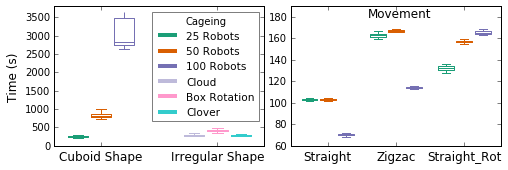

In [70]:
fig, ax = plt.subplots(1, 2,figsize=(8,2.5))
plt.subplots_adjust(hspace = 0.0,wspace = 0.13)

legend_titles = ['Cageing', 'Movement']

state = 0
path ='straight'
robot_1 = []
robot_2 = []
robot_3 = []


ticks = ['Cuboid Shape', 'Irregular Shape']

lin_1 = ax[state].boxplot([(data.stack()[25][0][path][state]/TIME_STEP)], positions=np.array(xrange(1))*3.0-0.8, sym='', widths=0.7)
lin_2 = ax[state].boxplot([(data.stack()[50][1][path][state]/TIME_STEP)], positions=np.array(xrange(1))*3.0, sym='', widths=0.7)
lin_3 = ax[state].boxplot([(data.stack()[100][2][path][state]/TIME_STEP)], positions=np.array(xrange(1))*3.0+0.8, sym='', widths=0.7)

set_box_color(lin_1, '#1b9e77') # colors are from http://colorbrewer2.org/
set_box_color(lin_2, '#d95f02')
set_box_color(lin_3, '#7570b3')

lin_4 = ax[state].boxplot([(data.stack()[30][3]['n'][state]/TIME_STEP)], positions=np.array([1])*4.0-0.8, sym='', widths=0.7)
lin_5 = ax[state].boxplot([(data.stack()[30][4]['n'][state]/TIME_STEP)], positions=np.array([1])*4.0, sym='', widths=0.7)
lin_6 = ax[state].boxplot([(data.stack()[30][5]['n'][state]/TIME_STEP)], positions=np.array([1])*4.0+0.8, sym='', widths=0.7)

set_box_color(lin_4, '#bebada') # colors are from http://colorbrewer2.org/
set_box_color(lin_5, '#ff99cc')
set_box_color(lin_6, '#33cccc')

# draw temporary red and blue lines and use them to create a legend
ax[state].plot([], c='#1b9e77',linewidth=4, label='25 Robots')
ax[state].plot([], c='#d95f02',linewidth=4, label='50 Robots')
ax[state].plot([], c='#7570b3',linewidth=4, label='100 Robots')

ax[state].plot([], c='#bebada',linewidth=4, label='Cloud')
ax[state].plot([], c='#ff99cc',linewidth=4, label='Box Rotation')
ax[state].plot([], c='#33cccc',linewidth=4, label='Clover')

#     ax[state].legend(title=legend_titles[state], loc=2,ncol=3,framealpha=0.5,fontsize=13)
ax[state].set_xticks([0,4])
ax[state].set_xticklabels(ticks,fontsize=12)
ax[state].set_xlim(-1.6,5.6)
ax[state].set_ylim(0,3800)

state = 1
ticks = ['Straight','Zigzac','Straight_Rot']
robot_1 = []
robot_2 = []
robot_3 = []

for path in PATH_TAKEN:
        data_tab = (data.stack()[25][0][path][state]/TIME_STEP)
        if(state > 0):
            data_tab = ((data.stack()[25][0][path][state] - data.stack()[25][0][path][state-1])/TIME_STEP)
        robot_1.append(data_tab)
        data_tab = (data.stack()[50][1][path][state]/TIME_STEP)
        if(state > 0):
            data_tab = ((data.stack()[50][1][path][state] - data.stack()[50][1][path][state-1])/TIME_STEP)
        robot_2.append(data_tab)
        data_tab = (data.stack()[100][2][path][state]/TIME_STEP)
        if(state > 0):
            data_tab = ((data.stack()[100][2][path][state] - data.stack()[100][2][path][state-1])/TIME_STEP)
        robot_3.append(data_tab)
lin_1 = ax[state].boxplot(robot_1, positions=np.array(xrange(len(PATH_TAKEN)))*3.0-0.8, sym='', widths=0.7)
lin_2 = ax[state].boxplot(robot_2, positions=np.array(xrange(len(PATH_TAKEN)))*3.0, sym='', widths=0.7)
lin_3 = ax[state].boxplot(robot_3, positions=np.array(xrange(len(PATH_TAKEN)))*3.0+0.8, sym='', widths=0.7)

set_box_color(lin_1, '#1b9e77') # colors are from http://colorbrewer2.org/
set_box_color(lin_2, '#d95f02')
set_box_color(lin_3, '#7570b3')

# draw temporary red and blue lines and use them to create a legend
ax[state].plot([], c='#1b9e77',linewidth=4, label='25 Robots')
ax[state].plot([], c='#d95f02',linewidth=4, label='50 Robots')
ax[state].plot([], c='#7570b3',linewidth=4, label='100 Robots')

#     ax[state].legend(title=legend_titles[state], loc=2,ncol=3,framealpha=0.5,fontsize=13)
ax[state].set_xticks([0,3,6])
ax[state].set_xticklabels(ticks,fontsize=12)
ax[state].set_xlim(-1.6,7.6)
ax[state].set_ylim(60,190)



# legend for last state only
ax[0].legend(title=legend_titles[0],loc=1,ncol=1,framealpha=0.5,fontsize=10.5)   
# y lable for first plot
ax[0].set_ylabel("Time (s)",fontsize=12)
# Add state titles to the plot
# plt.figtext(0.27, 0.84, legend_titles[0], color='black', weight='roman',
#         size=12)
plt.figtext(0.67, 0.84, legend_titles[1], color='black', weight='roman',
        size=12)
plt.savefig("/home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/time_taken.pdf", dpi=600, format="pdf", transparent=False)

In [71]:
%%bash
pdfcrop /home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/time_taken.pdf /home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/time_taken.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `/home/vivek/Vivek/Projects/Collobrative_transport/Data_processing/PLOTS/time_taken.pdf'.
